- Lilian
 - [Policy Gradient Algorithms](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)

 

$$
\begin{align*}
&\textbf{function REINFORCE} \\
&\quad \text{Initialise } \theta \text{ arbitrarily} \\
&\quad \textbf{for} \hspace{0.5em} \text{each episode } \{s_1, a_1, r_2, \ldots, s_{T-1}, a_{T-1}, r_T\} \sim \pi_\theta \text{ do} \\
&\qquad \text{for } t = 1 \text{ to } T - 1 \text{ do} \\
&\qquad\quad \theta \leftarrow \theta + \alpha \nabla_\theta \log \pi_\theta(s_t, a_t) v_t \\
&\qquad \textbf{end for} \\
&\quad \textbf{end for} \\
&\quad \textbf{return } \theta \\
&\textbf{end function}
\end{align*}
$$

- 需要注意的是我们希望reward越大越好（梯度上升），但是神经网络使用的是梯度下降减少loss；

total returned reward $v_t or G_t$
- $v_t or G_t = \sum^{\infty}_{k=0}{\gamma^kR_{t+k+1}}$
  - 减少未来的reward
  - 当前动作的 reward 通过基于当前状态的未来 reward 折现进行估计；

- policy gradient algorithm
  - Perform a trajectory/roll-out(mcts) using the current policy to fixed $\pi_\theta(a_t,s_t)$
    - trajectory：$\tau=(s_1,a_1,r_2,s_2,a_2,r_3, \cdots)$
        ```
        s = env.reset()
        a, log_p = policy(s)
        next_state, reward, done, _ = env.step(a)
        if done == True:
            break
        s = next_state
        ```
    - Store **log** probabilities (of policy, $\log\pi_\theta(a_t|s_t)$) and reward values at each step
        - 概率通过 policy network 获得；
- Calculate **discounted cumulative future reward**($G_t$) at each step
- Compute policy gradient ($\nabla J(\theta)$) and update policy parameter（gradient descent）
    - 反向传播，梯度更新是神经网络帮我们完成的
    - loss = $-\sum_{t}\log(\pi_{\theta}(a_t|s_t))G_t$
    - `loss.backward()`
- Repeat 1–3

# *Summary*
- Q-learning --> DQN
  - 使用 net 逼近 Q function ($Q(s_t, a_t)$, action values)
  - 输出的是action values

- policy gradient --> DPG(Deep policy gradient)
  - net 逼近 $\pi_\theta(a_t| s_t) $
  - 输出的是概率分布(在最后一层加入softmax)

```pyhon

# REINFORCE (policy gradient) 
# -----------------------------------------------------

# 1. 初始化
policy = PolicyNetwork()          # πθ(a|s)
optimizer = Adam(policy.parameters(), lr=α)

for episode in range(max_episodes):
    # 2. 采样一条轨迹 τ = (s0,a0,r1, s1,a1,r2, ..., sT)
    trajectory = []
    state = env.reset()
    done  = False
    while not done:
        action, log_prob = policy.sample_action(state)  # 同时返回 log πθ
        next_state, reward, done = env.step(action)
        trajectory.append((state, action, reward, log_prob))
        state = next_state

    # 3. 计算折扣回报 G_t
    returns = []
    G = 0
    for (_, _, r, _) in reversed(trajectory):
        G = r + γ * G
        returns.insert(0, G)      # 倒序插到最前
    returns = normalize(returns)  # 可选：标准化

    # 4. 构造损失并更新
    loss = 0
    for (log_prob, G_t) in zip([log_prob for (_,_,_,log_prob) in trajectory], returns):
        loss += -log_prob * G_t   # REINFORCE 梯度估计
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ```

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib as plt



In [2]:
# 1. 超参数
ENV_NAME = "CartPole-v1"
LR= 1e-3
GAMMA = 0.99
MAX_EPISODES = 1000
PRINT_INTERVAL = 20

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, s_size=4, a_size=2, hidden=128):
        super().__init__()
        self.fc1 = nn.Linear(s_size, hidden)
        self.fc2 = nn.Linear(hidden, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # 输出动作概率
    
    def act(self, state):
        state = torch.as_tensor(state, 
                                dtype=torch.float32, 
                                device=device).unsqueeze(0) # [s,] -> [1,s]
        probs = self.forward(state)

        # 依概率采样
        m = Categorical(probs) 
        action = m.sample()

        # PyTorch 的 Categorical 通过 log_prob 保留了梯度链路
        return action.item(), m.log_prob(action)
    

In [5]:
# 3. 计算折扣回报G_t
def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, device=device)
    # 标准化（可选，但通常能加速收敛）
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns


In [6]:
# 4. 训练主循环
def reinforce():
    env = gym.make(ENV_NAME)
    policy = PolicyNet().to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=LR)

    scores = []  # 记录每回合总回报
    avg_scores = []
    
    for episode in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        log_probs = []
        rewards = []

        while True:
            action, log_prob = policy.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            if done:
                break

        # 计算损失并更新
        returns = compute_returns(rewards, GAMMA)
        log_probs = torch.stack(log_probs)
        loss = []
        for log_prob, R in zip(log_probs, returns):
            loss.append(-log_prob * R)  # REINFORCE 梯度公式 最小化所以取负值
        loss = torch.stack(loss).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scores.append(sum(rewards))
        avg_score = np.mean(scores[-PRINT_INTERVAL:])
        avg_scores.append(avg_score)
        
        if episode % PRINT_INTERVAL == 0:
            print(f"Episode {episode}\tAverage Score: {avg_score:.2f}")

    env.close()
    return scores, avg_scores

In [7]:
scores, avg_score = reinforce()

Episode 20	Average Score: 15.30
Episode 40	Average Score: 22.95
Episode 60	Average Score: 31.85
Episode 80	Average Score: 29.85
Episode 100	Average Score: 31.70
Episode 120	Average Score: 33.15
Episode 140	Average Score: 29.95
Episode 160	Average Score: 49.10
Episode 180	Average Score: 58.30
Episode 200	Average Score: 68.90
Episode 220	Average Score: 62.50
Episode 240	Average Score: 72.50
Episode 260	Average Score: 131.00
Episode 280	Average Score: 133.20
Episode 300	Average Score: 185.30
Episode 320	Average Score: 225.60
Episode 340	Average Score: 199.35
Episode 360	Average Score: 246.90
Episode 380	Average Score: 299.50
Episode 400	Average Score: 323.10
Episode 420	Average Score: 247.55
Episode 440	Average Score: 253.30
Episode 460	Average Score: 275.55
Episode 480	Average Score: 273.05
Episode 500	Average Score: 346.15
Episode 520	Average Score: 381.75
Episode 540	Average Score: 446.65
Episode 560	Average Score: 387.65
Episode 580	Average Score: 444.35
Episode 600	Average Score: 435

C:\Users\hhm18\AppData\Local\Temp\ipykernel_22924\1009111582.py:5: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend("scores", "avg_score")
C:\Users\hhm18\AppData\Local\Temp\ipykernel_22924\1009111582.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("scores", "avg_score")


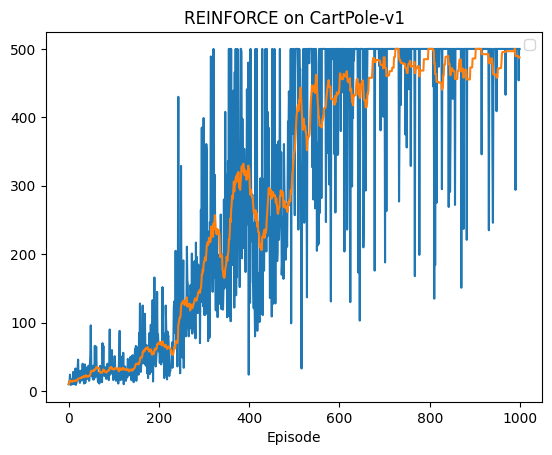

In [8]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.plot(avg_score)
plt.legend("scores", "avg_score")
plt.title("REINFORCE on CartPole-v1")
plt.xlabel("Episode")
plt.show()